<a href="https://colab.research.google.com/github/prajapatiraghulal/Anomaly_detection/blob/master/anomaly_detection_via_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib
!pip install mxnet-cu101==1.7.0.post0
!pip install sklearn
!pip install pandas
!pip install statsmodels
!pip install plotly

     |███████████████████████████████▌| 834.1MB 1.2MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x5588bfb56000 @  0x7fa979957615 0x558886f81cdc 0x55888706152a 0x558886f84afd 0x558887075fed 0x558886ff8988 0x558886ff34ae 0x558886f863ea 0x558886ff87f0 0x558886ff34ae 0x558886f863ea 0x558886ff532a 0x558887076e36 0x558886ff4853 0x558887076e36 0x558886ff4853 0x558887076e36 0x558886ff4853 0x558887076e36 0x558886ff4853 0x558886f8630a 0x558886ff460e 0x558886ff37ad 0x558886f863ea 0x558886ff43b5 0x558886f8630a 0x558886ff43b5 0x558886ff34ae 0x558886f863ea 0x558886ff532a 0x558886ff34ae
     |████████████████████████████████| 846.4MB 22kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import mxnet 
from mxnet.gluon import nn
from mxnet import gluon, image, npx,np
import matplotlib.pyplot as plt
import numpy
import cv2
from mxnet.gluon.model_zoo import vision
import os
import pandas as pd
import numpy
from mxnet.gluon import nn,rnn
from mxnet import init,autograd
npx.set_np()
import sklearn 


In [4]:
import json
from pathlib import Path
from IPython import display
%matplotlib inline
npx.set_np()

In [5]:
nab = Path.cwd()/r'drive/MyDrive/projects/anomaly_data'
data_path = nab/r'data'
labels_filepath = nab/r'labels/combined_labels.json'

In [6]:
training_filename =r'realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv'

valid_filename = r'realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv'

In [7]:
with open(labels_filepath,'r') as f:
    anomalies_timestamps = json.load(f)
    train_data_anomalies = anomalies_timestamps[training_filename]
    valid_data_anomalies = anomalies_timestamps[valid_filename]
    #print(train_data_anomalies, valid_data_anomalies)



In [8]:
train_pd = pd.read_csv(data_path/training_filename)
valid_pd = pd.read_csv(data_path/valid_filename)
print(train_pd.head(), valid_pd.head())

             timestamp  value
0  2014-02-14 14:30:00  6.456
1  2014-02-14 14:35:00  5.816
2  2014-02-14 14:40:00  6.268
3  2014-02-14 14:45:00  5.816
4  2014-02-14 14:50:00  5.862              timestamp   value
0  2014-04-10 00:02:00  14.012
1  2014-04-10 00:07:00  13.334
2  2014-04-10 00:12:00  15.000
3  2014-04-10 00:17:00  13.998
4  2014-04-10 00:22:00  14.332


In [9]:
def normalization(data):
    '''normalizes numpy data with sd=1, and mean=0'''
    mean = data.mean(keepdims=False)
    var = ((data-mean)**2).mean(keepdims=False)
    normalized_data = (data-mean)/np.sqrt(var)
    return normalized_data
    

In [10]:
#train and validation  data 
train_value = np.array(train_pd['value'], dtype=np.float32)
valid_value = np.array(valid_pd['value'], dtype=np.float32)

train_pd['normalize value'] =(normalization(train_value))
valid_pd['normalize value'] =(normalization(valid_value))




In [11]:
train_value.dtype

dtype('float32')

In [12]:
train_anomalies = train_pd[train_pd['timestamp'].isin(train_data_anomalies)]
valid_anomalies = valid_pd[valid_pd['timestamp'].isin(valid_data_anomalies)]

In [75]:
train_anomalies

Int64Index([3080, 3579], dtype='int64')

In [14]:
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')


In [15]:
def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

In [16]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

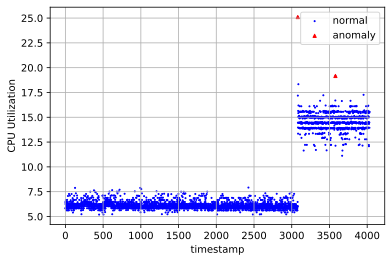

In [17]:
set_figsize((6,4))

axes = plt.gca()
axes.scatter(train_pd.iloc[:,0],train_pd.iloc[:,1],marker='.',s=5,c='blue' )
axes.scatter(train_anomalies.iloc[:,0],train_anomalies.iloc[:,1],marker='^',s=10,c='red')
set_axes(axes, xlabel='timestamp', ylabel='CPU Utilization', xlim=None, ylim=None, xscale='linear', yscale='linear', legend=['normal','anomaly'])

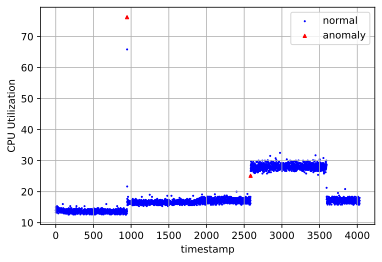

In [18]:
set_figsize((6,4))

axes = plt.gca()
axes.scatter(valid_pd.iloc[:,0],valid_pd.iloc[:,1],marker='.',s=5,c='blue' )
axes.scatter(valid_anomalies.iloc[:,0],valid_anomalies.iloc[:,1],marker='^',s=10,c='red')
set_axes(axes, xlabel='timestamp', ylabel='CPU Utilization', xlim=None, ylim=None, xscale='linear', yscale='linear', legend=['normal','anomaly'])

In [19]:

from mxnet.gluon.data import Dataset,dataloader


In [20]:
#just creating 2nd reference name to train and valid value arrays
train_array = train_value
valid_array = valid_value

In [21]:
def load_array(data_arrays, batch_size):
    """Construct a Gluon data iterator."""
    dataset = gluon.data.ArrayDataset(*data_arrays)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=False)

In [22]:
#to create iterable object of data with batch size of 64
batch_size =64

temp = list(train_pd['normalize value'])
temp.append(temp[-1])
train_value = np.array(temp)
train_iter= load_array((train_value[:-1],train_value[1:]),batch_size)

temp = list(valid_pd['normalize value'])
temp.append(temp[-1])
valid_value = np.array(temp)
valid_iter= load_array((valid_value[:-1],valid_value[1:]),batch_size)

In [23]:
#for i,(X,y) in enumerate(valid_iter):
#  print(i, X.shape, y.shape)
#  if(i==62):
#   print(X,y)

In [24]:


## creating RNN MODEL SPECIFIC LSTM

In [25]:
num_hiddens = 128
rnn_layer = rnn.RNN(num_hiddens)
rnn_layer.initialize()

In [26]:
state = rnn_layer.begin_state(batch_size=64)
len(state)

1

In [27]:
state[0].dtype

dtype('float32')

In [28]:
class RNN_model(nn.Block):
  def __init__(self, rnn_layer, length=1, **kwargs):
    super(RNN_model, self).__init__(**kwargs)
    self.rnn = rnn_layer
    self.length = length
    self.dense = nn.Dense(self.length)
    
    
  def forward(self, inputs, state):
    X = inputs
    Y, state= self.rnn(X,state)
    output = self.dense(Y.reshape(-1,128))
    return output, state
  
  def begin_state(self, *args, **kwargs):
    self.rnn.begin_state(*args,**kwargs)

In [29]:
net = RNN_model(rnn_layer)
net.initialize(force_reinit=True)

In [30]:
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'Adam',{'learning_rate':.02})
epochs = 16



In [31]:
train_loss=[]
valid_loss=[]


In [32]:

for epoch in range(epochs):
  ll=0.0
  for i,(X,y) in enumerate(train_iter):
    with autograd.record():
      Y,state = net(X.reshape(1,64,-1),state)
      #print(Y,y)
      l= loss(Y.reshape(-1),y)
    l.backward()
    ll+=l.sum()
    #print(l.sum())
    #print(Y.shape)
    trainer.step(1)
  print(ll,end='\t')
  train_loss.append(ll)
  #print('***************************************')
  lll=0.0
  for i,(X,y) in enumerate(valid_iter):
    Y,state = net(X.reshape(1,64,-1),state)
    lo = loss(Y.reshape(y.shape),y)
    lll+=lo.sum()

  print(lll)
  valid_loss.append(lll)

    

1164.8196	1322.1389
4696.8306	1855.2402
690.46155	1032.4711
801.58026	1533.0139
1524.6761	1698.0421
521.18054	1141.8741
412.24072	499.83435
213.2843	524.48065
129.6357	164.61139
98.95444	174.27083
81.45559	187.10616
78.39382	206.58626
78.80047	224.74974
81.05719	236.77434
84.14344	221.57573
80.13223	199.6895


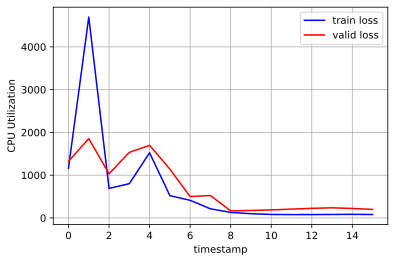

In [33]:
set_figsize((6,4))

axes = plt.gca()
axes.plot(range(16),train_loss,c='blue' )
axes.plot(range(16),valid_loss,c='red')
set_axes(axes, xlabel='timestamp', ylabel='CPU Utilization', xlim=None, ylim=None, xscale='linear', yscale='linear', legend=['train loss','valid loss'])

In [34]:
## I can clearly see epoch no. 16 is best with both losses min compare to others 

In [35]:
lll=0.0
y_predict = []
x_predict=[]
for i,(X,y) in enumerate(valid_iter):
  Y,state = net(X.reshape(1,64,-1),state)
  y_predict.append(Y.reshape(-1))
  x_predict.append(X)
  lll+=lo.sum()
  
print(lll)

65.82364


In [82]:
# xx,yy are nothing but predicted
xx= np.array(x_predict).reshape(-1)
yy= np.array(y_predict).reshape(-1)

In [83]:
loss = (xx-yy)**2
loss.sum()/(64*63)   #loss per value

array(0.03414752)

array(0.03414752)

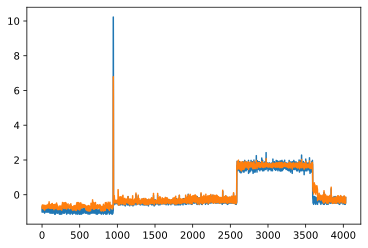

In [84]:
plt.plot(xx.asnumpy())
plt.plot(yy.asnumpy())


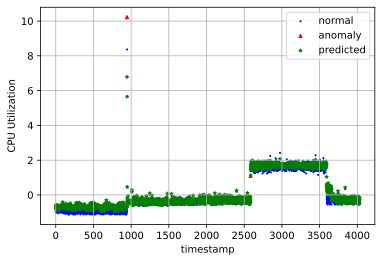

In [85]:
set_figsize((6,4))

axes = plt.gca()
axes.scatter(valid_pd.iloc[:,0],valid_pd.iloc[:,2],marker='.',s=5,c='blue' )
axes.scatter(valid_anomalies.iloc[:,0],valid_anomalies.iloc[:,2],marker='^',s=10,c='red')
axes.scatter(valid_pd.iloc[:,0], yy, marker='*',s=10, c='green')
set_axes(axes, xlabel='timestamp', ylabel='CPU Utilization', xlim=None, ylim=None, xscale='linear', yscale='linear', legend=['normal','anomaly','predicted'])

In [43]:
lll=0.0
y_train_predict = []
x_train_predict=[]
for i,(X,y) in enumerate(train_iter):
  Y,state = net(X.reshape(1,64,-1),state)
  
  y_train_predict.append(Y.reshape(-1))
  x_train_predict.append(X)
  lll+=lo.sum()
  
print(lll)

65.82364


In [44]:

##xxx,yyy is nothing but predicted x_train, y_train
xxx= np.array(x_train_predict).reshape(-1)
yyy= np.array(y_train_predict).reshape(-1)

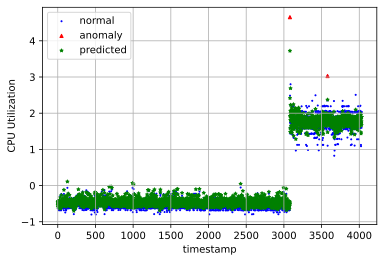

In [45]:
set_figsize((6,4))

axes = plt.gca()
axes.scatter(train_pd.iloc[:,0],train_pd.iloc[:,2],marker='.',s=5,c='blue' )
axes.scatter(train_anomalies.iloc[:,0],train_anomalies.iloc[:,2],marker='^',s=10,c='red')
axes.scatter(train_pd.iloc[:,0], yyy, marker='*',s=10, c='green')
set_axes(axes, xlabel='timestamp', ylabel='CPU Utilization', xlim=None, ylim=None, xscale='linear', yscale='linear', legend=['normal','anomaly','predicted'])

In [86]:

def calculate_prediction_errors(XXX,YYY):
    return (np.abs(XXX -YYY))

train_pred_errors = calculate_prediction_errors(xxx,yyy).reshape(-1)
valid_pred_errors = calculate_prediction_errors(xx,yy).reshape(-1)

In [87]:
train_pred_thresh = train_pred_errors.mean() +3*np.std(train_pred_errors)
valid_pred_thresh = valid_pred_errors.mean() +3*np.std(valid_pred_errors)

In [88]:
idx = np.abs(train_pred_errors-train_pred_thresh)>train_pred_thresh
idv = np.abs(valid_pred_errors-valid_pred_thresh)>valid_pred_thresh

In [89]:
predict_train_anomaly=xxx[np.abs(train_pred_errors-train_pred_thresh)>train_pred_thresh]
predict_valid_anomaly=xx[np.abs(valid_pred_errors-valid_pred_thresh)>valid_pred_thresh]

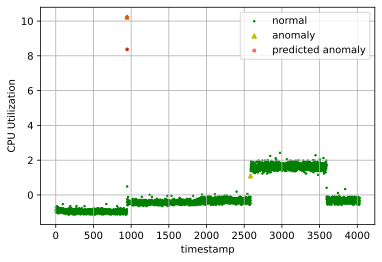

In [90]:
set_figsize((6,4))
axes = plt.gca()

axes.scatter(np.arange(4032).asnumpy(),xx.asnumpy(), c='g',s=10, marker='.')
axes.scatter(valid_anomalies.index,valid_anomalies.iloc[:,2],marker='^',s=20,c='y')
axes.scatter(np.arange(4032)[idv].asnumpy(),predict_valid_anomaly.asnumpy(), c='r',s=10, marker='o', alpha=0.5)
set_axes(axes, xlabel='timestamp', ylabel='CPU Utilization', xlim=None, ylim=None, xscale='linear', yscale='linear', legend=['normal','anomaly','predicted anomaly'])

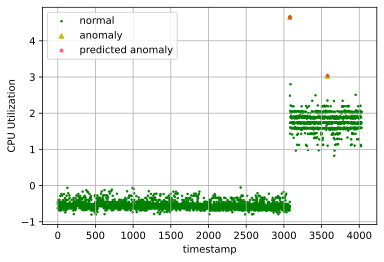

In [78]:
set_figsize((6,4))
axes = plt.gca()

axes.scatter(np.arange(4032).asnumpy(),xxx.asnumpy(), c='g',s=10, marker='.')
axes.scatter(train_anomalies.index,train_anomalies.iloc[:,2],marker='^',s=20,c='y')
axes.scatter(np.arange(4032)[idx].asnumpy(),predict_train_anomaly.asnumpy(), c='r',s=10, marker='o', alpha=0.5)
set_axes(axes, xlabel='timestamp', ylabel='CPU Utilization', xlim=None, ylim=None, xscale='linear', yscale='linear', legend=['normal','anomaly','predicted anomaly'])